In [1]:
import h5py
import numpy as np

patch_file = "/kaggle/input/rsna-patches-dataset/patches.h5"
f_patch = h5py.File(patch_file, "r")
X_grp_patch, y_grp_patch, meta_grp_patch = f_patch["X"], f_patch["y"], f_patch["meta"]


data_file = "/kaggle/input/rsna-dataset/dataset.h5"
f_data = h5py.File(data_file, "r")
X_grp_data, y_grp_data, meta_grp_data = f_data["X"], f_data["y"], f_data["meta"]

In [2]:
from sklearn.model_selection import train_test_split

series_uids = list(X_grp_data.keys())
series_uids = np.array(series_uids)

# 60/20/20
train_uids, test_uids = train_test_split(series_uids, test_size=0.2, random_state=42)
train_uids, val_uids = train_test_split(train_uids, test_size=0.25, random_state=42)

print(f"Train séries: {len(train_uids)}, Val: {len(val_uids)}, Test: {len(test_uids)}")

Train séries: 2608, Val: 870, Test: 870


In [3]:
import json

meta_ds = meta_grp_data[:]
idx2uid = {str(m["h5_index"]): m["series_uid"].decode() if isinstance(m["series_uid"], bytes) else m["series_uid"]
               for m in meta_ds}

train_uids_str = set(idx2uid[i] for i in train_uids)
val_uids_str   = set(idx2uid[i] for i in val_uids)
test_uids_str  = set(idx2uid[i] for i in test_uids)

print("Exemple UID train :", list(train_uids_str)[:3])


Exemple UID train : ['1.2.826.0.1.3680043.8.498.14008381437775466142335715827326866692', '1.2.826.0.1.3680043.8.498.80357948446147702581203269899687979566', '1.2.826.0.1.3680043.8.498.71847505042271018869837684830697171879']


In [4]:
from tqdm import tqdm

splits = {"train": [], "val": [], "test": []}

bar = tqdm(desc="Scan patches", unit="patch", dynamic_ncols=True)
for k in meta_grp_patch:
    meta_str = meta_grp_patch[k][()].decode("utf-8")
    meta = json.loads(meta_str)
    uid = meta["series_uid"]

    if uid in train_uids_str:
        splits["train"].append(int(k))
    elif uid in val_uids_str:
        splits["val"].append(int(k))
    elif uid in test_uids_str:
        splits["test"].append(int(k))

    bar.update(1)
bar.close()

for split in ["train", "val", "test"]:
    print(f"{split}: {len(splits[split])} patches")


Scan patches: 970975patch [18:36, 869.52patch/s] 

train: 578757 patches
val: 206681 patches
test: 185537 patches


In [5]:

def count_pos_neg(y_grp, ids):
    pos = neg = 0
    for i in tqdm(ids, desc="Counting pos/neg"):
        label = int(y_grp[str(i)][()])
        if label == 1:
            pos += 1
        else:
            neg += 1
    return pos, neg

pos_tr, neg_tr = count_pos_neg(y_grp_patch, splits["train"])
print("Train:", pos_tr, "positifs,", neg_tr, "négatifs")


Counting pos/neg: 100%|██████████| 578757/578757 [02:35<00:00, 3714.32it/s]

Train: 1854 positifs, 576903 négatifs


In [6]:
N = pos_tr + neg_tr
w_pos = N / (2.0 * pos_tr) if pos_tr > 0 else 1.0
w_neg = N / (2.0 * neg_tr) if neg_tr > 0 else 1.0

class_weights = {0: w_neg, 1: w_pos}
print("class_weights:", class_weights)

class_weights: {0: 0.501606855918586, 1: 156.08333333333334}


In [7]:
def patch_generator(X_grp, y_grp, patch_ids, batch_size=32, shuffle=True, normalize=True, w_pos=1.0, w_neg=1.0):
    ids = np.array(patch_ids)
    n = len(ids)

    while True:
        if shuffle:
            np.random.shuffle(ids)

        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_ids = ids[start:end]

            X_batch = [X_grp[str(i)][()] for i in batch_ids]
            y_batch = np.array([int(y_grp[str(i)][()]) for i in batch_ids], dtype=np.int32)

            X_batch = np.array(X_batch, dtype=np.float32)
            if normalize:
                X_batch /= 7.0

            sw = np.where(y_batch == 1, w_pos, w_neg).astype(np.float32)

            yield X_batch, y_batch, sw


In [8]:
def balanced_epoch_gen(X_grp, y_grp, patch_ids, batch_size=32, neg_ratio=4, shuffle=True, normalize=True, w_pos=1.0, w_neg=1.0):
    pos_ids = [i for i in patch_ids if int(y_grp[str(i)][()]) == 1]
    neg_ids_all = [i for i in patch_ids if int(y_grp[str(i)][()]) == 0]

    print(f"[INFO] {len(pos_ids)} pos, {len(neg_ids_all)} neg (pool)")

    while True:  # boucle infinie pour Keras
        n_neg = neg_ratio * len(pos_ids)
        neg_ids = list(np.random.choice(neg_ids_all, size=n_neg, replace=False))

        epoch_ids = np.array(pos_ids + neg_ids)
        if shuffle:
            np.random.shuffle(epoch_ids)

        for start in range(0, len(epoch_ids), batch_size):
            end = min(start + batch_size, len(epoch_ids))
            batch_ids = epoch_ids[start:end]

            Xb = [X_grp[str(i)][()] for i in batch_ids]
            yb = np.array([int(y_grp[str(i)][()]) for i in batch_ids], dtype=np.int32)

            Xb = np.array(Xb, dtype=np.float32)
            if normalize:
                Xb /= 7.0

            # sample_weight : pondère si tu veux en plus de l’équilibrage
            sw = np.where(yb == 1, w_pos, w_neg).astype(np.float32)

            yield Xb, yb, sw

In [9]:
batch_size = 32

neg_ratio = 4

w_pos = 2.0
w_neg = 1.0 / neg_ratio
class_weights = {0: w_neg, 1: w_pos}
print("class_weights:", class_weights)

train_gen = balanced_epoch_gen(
    X_grp_patch,
    y_grp_patch,
    splits["train"],
    batch_size=batch_size,
    neg_ratio=neg_ratio,   # 4x plus de négatifs
    shuffle=True,
    w_pos=w_pos,
    w_neg=w_neg
)




val_gen = patch_generator(  # val normal (pas équilibré)
    X_grp_patch,
    y_grp_patch,
    splits["val"],
    batch_size=batch_size,
    shuffle=False
)


test_gen = patch_generator(
    X_grp_patch, y_grp_patch,
    splits["test"], batch_size=batch_size, shuffle=False
)



# Vérification rapide
Xb, yb, sw = next(train_gen)
print("Train batch:", Xb.shape, yb.shape, sw.shape)
print("Sample weights:", sw[:10])

class_weights: {0: 0.25, 1: 2.0}
[INFO] 1854 pos, 576903 neg (pool)
Train batch: (32, 64, 64, 64, 1) (32,) (32,)
Sample weights: [0.25 0.25 0.25 2.   0.25 0.25 0.25 0.25 0.25 2.  ]


In [10]:
import numpy as np

def save_generator_state(path, patch_ids, batch_size, neg_ratio=None, w_pos=1.0, w_neg=1.0, shuffle=True):
    np.savez(
        path,
        patch_ids=np.array(patch_ids, dtype=np.int32),
        batch_size=batch_size,
        neg_ratio=neg_ratio if neg_ratio is not None else -1,
        w_pos=w_pos,
        w_neg=w_neg,
        shuffle=shuffle
    )
    print(f"Générateur sauvegardé dans {path}")

In [11]:
save_generator_state("/kaggle/working/train_gen.npz", splits["train"], batch_size, neg_ratio=4, w_pos=w_pos, w_neg=w_neg)
save_generator_state("/kaggle/working/val_gen.npz",   splits["val"], batch_size, w_pos=w_pos, w_neg=w_neg, shuffle=False)
save_generator_state("/kaggle/working/test_gen.npz",  splits["test"], batch_size, w_pos=w_pos, w_neg=w_neg, shuffle=False)


Générateur sauvegardé dans /kaggle/working/train_gen.npz
Générateur sauvegardé dans /kaggle/working/val_gen.npz
Générateur sauvegardé dans /kaggle/working/test_gen.npz


In [12]:
def load_generator_state(path, X_grp_patch, y_grp_patch, mode="train"):

    data = np.load(path, allow_pickle=True)
    patch_ids = data["patch_ids"].tolist()
    batch_size = int(data["batch_size"])
    neg_ratio = int(data["neg_ratio"]) if "neg_ratio" in data and data["neg_ratio"] >= 0 else None
    w_pos = float(data["w_pos"])
    w_neg = float(data["w_neg"])
    shuffle = bool(data["shuffle"])

    print(f"📂 Rechargement du générateur {mode}: {len(patch_ids)} patchs | batch_size={batch_size}")

    if mode == "train" and neg_ratio is not None and neg_ratio > 0:
        gen = balanced_epoch_gen(
            X_grp_patch, y_grp_patch,
            patch_ids,
            batch_size=batch_size,
            neg_ratio=neg_ratio,
            shuffle=shuffle,
            w_pos=w_pos,
            w_neg=w_neg
        )
    else:
        gen = patch_generator(
            X_grp_patch, y_grp_patch,
            patch_ids,
            batch_size=batch_size,
            shuffle=shuffle,
            w_pos=w_pos,
            w_neg=w_neg
        )

    return gen

In [22]:
train_gen = load_generator_state("/kaggle/working/train_gen.npz", X_grp_patch, y_grp_patch, mode="train")
val_gen   = load_generator_state("/kaggle/working/val_gen.npz",   X_grp_patch, y_grp_patch, mode="val")
test_gen  = load_generator_state("/kaggle/working/test_gen.npz",  X_grp_patch, y_grp_patch, mode="test")

# Test rapide
Xb, yb, sw = next(train_gen)
print("Batch shape:", Xb.shape, "Labels:", np.unique(yb), "Weights:", sw[:5])

📂 Rechargement du générateur train: 578757 patchs | batch_size=32
📂 Rechargement du générateur val: 206681 patchs | batch_size=32
📂 Rechargement du générateur test: 185537 patchs | batch_size=32
[INFO] 1854 pos, 576903 neg (pool)
Batch shape: (32, 64, 64, 64, 1) Labels: [0 1] Weights: [  0.5016069   0.5016069   0.5016069   0.5016069 156.08333  ]


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

input_shape = (64, 64, 64, 1)
EPS = 1e-7

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * tf.pow((1 - p_t), gamma) * bce
    return loss

def f1_tf(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred >= 0.5, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + EPS)
    recall = tp / (tp + fn + EPS)
    return 2 * precision * recall / (precision + recall + EPS)

def build_model():
    model = models.Sequential([
        layers.Conv3D(32, 3, padding="same", activation="relu", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling3D(2),

        layers.Conv3D(64, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling3D(2),

        layers.Conv3D(128, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling3D(2),

        layers.Conv3D(256, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling3D(),

        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
        loss=focal_loss(gamma=0., alpha=1.),
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            f1_tf,
        ]
    )
    return model

model = build_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 64, 64, 64, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 32, 32, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 32, 32, 32, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 16, 16, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 16, 16, 16,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 16,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 8, 8, 8, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 8, 8, 8, 256)   │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 8, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,197,505 (4.57 MB)

 Trainable params: 1,196,545 (4.56 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
nb_models = 1

In [14]:
models_folds = []
for i in range(nb_models):
    m = build_model()
    models_folds.append(m)
    print(f"✅ Modèle {i+1} initialisé avec {m.count_params():,} paramètres")

✅ Modèle 1 initialisé avec 1,197,505 paramètres


In [15]:
from sklearn.metrics import roc_auc_score, confusion_matrix
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

class RandomValSubset(Callback):
    def __init__(self, X_grp, y_grp, all_val_ids,
                 batch_size=32, frac=0.08, threshold=0.5, fold_id=None):
        self.X_grp = X_grp
        self.y_grp = y_grp
        self.all_val_ids = np.array(all_val_ids)
        self.batch_size = batch_size
        self.frac = frac
        self.threshold = threshold
        self.fold_id = fold_id

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        n_all = len(self.all_val_ids)
        n_sub = max(self.batch_size, int(self.frac * n_all))
        n_sub = min(n_sub, n_all)

        subset = np.random.choice(self.all_val_ids, size=n_sub, replace=False)

        def val_generator(X_grp, y_grp, ids, batch_size=32):
            for start in range(0, len(ids), batch_size):
                end = min(start + batch_size, len(ids))
                batch_ids = ids[start:end]
                Xb = np.array([X_grp[str(i)][()] for i in batch_ids], np.float32) / 7.0
                yb = np.array([int(y_grp[str(i)][()]) for i in batch_ids], np.int32)
                yield Xb, yb

        y_true, y_prob = [], []
        print(f"\n[Fold {self.fold_id}] Epoch {epoch+1} — Validation (subset {len(subset)} patches)")
        for Xb, yb in tqdm(val_generator(self.X_grp, self.y_grp, subset, self.batch_size),
                           desc=f"Fold {self.fold_id} val", leave=False):
            pb = self.model.predict(Xb, verbose=0).ravel()
            # Nettoyage numérico-stable
            pb = np.nan_to_num(pb, nan=0.0, posinf=1.0, neginf=0.0)
            pb = np.clip(pb, 0.0, 1.0)
            y_true.append(yb)
            y_prob.append(pb)

        y_true = np.concatenate(y_true) if y_true else np.array([])
        y_prob = np.concatenate(y_prob) if y_prob else np.array([])

        if y_true.size == 0:
            print("[warn] subset vide → skip métriques.")
            return

        # Filtre sécurité
        mask = np.isfinite(y_prob)
        y_true = y_true[mask]
        y_prob = y_prob[mask]

        y_hat = (y_prob >= self.threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()

        recall = tp / (tp + fn + 1e-9)
        precision = tp / (tp + fp + 1e-9)
        acc = (tp + tn) / (tp + tn + fp + fn + 1e-9)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)
        specificity = tn / (tn + fp + 1e-9)
        bal_acc = 0.5 * (recall + specificity)
        gmean = np.sqrt(recall * specificity)

        # AUC si 2 classes présentes
        auc = np.nan
        if len(np.unique(y_true)) == 2:
            try:
                auc = roc_auc_score(y_true, y_prob)
            except ValueError:
                auc = np.nan

        logs["val_auc"] = auc
        logs["val_accuracy"] = acc
        logs["val_precision"] = precision
        logs["val_recall"] = recall
        logs["val_f1"] = f1
        logs["val_specificity"] = specificity
        logs["val_bal_acc"] = bal_acc
        logs["val_gmean"] = gmean

        print(
            f"[Fold {self.fold_id}] "
            f"AUC={auc:.3f} | Acc={acc:.3f} | Prec={precision:.3f} | Rec={recall:.3f} "
            f"| Spec={specificity:.3f} | F1={f1:.3f} | BA={bal_acc:.3f} | G={gmean:.3f} "
            f"| TP={tp} FN={fn} FP={fp} TN={tn}"
        )

def get_callbacks_for_fold(fold_id):
    early_stopping = EarlyStopping(
        monitor="val_gmean",
        mode="max",
        patience=10,
        restore_best_weights=True
    )
    checkpoint = ModelCheckpoint(
        f"/kaggle/working/model_best_fold{fold_id}.keras",
        monitor="val_gmean",
        mode="max",
        save_best_only=True,
        verbose=1
    )
    return [early_stopping, checkpoint]


In [16]:
steps_per_epoch = (2000 + 2000 * 4) // batch_size  # ≈ 312

for i, model in enumerate(models_folds):
    fold_id = i + 1
    print(f"\nEntraînement du modèle {fold_id}/{nb_models}")

    callbacks = [
        RandomValSubset(
            X_grp=X_grp_patch,
            y_grp=y_grp_patch,
            all_val_ids=splits["val"],
            batch_size=batch_size,
            frac=0.03,
            threshold=0.5,
            fold_id=fold_id
        ),
        *get_callbacks_for_fold(fold_id)
    ]

    tf.keras.utils.set_random_seed(42 + fold_id)

    history = model.fit(
        train_gen,
        epochs=100,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=1
    )

    model.save(f"/kaggle/working/model_final_fold{fold_id}.keras")
    print(f"Modèle {fold_id} sauvegardé !")



Entraînement du modèle 1/1
Epoch 1/100


I0000 00:00:1759676965.233263     105 service.cc:148] XLA service 0x797de80084d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759676965.234136     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759676965.234146     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759676966.133431     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-10-05 15:09:31.240526: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,32,32,32]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,32,32,32]{4,3,2,1,0}, f32[64,32,3,3,3]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":f

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6652 - auc: 0.8175 - f1_tf: 0.2756 - loss: 0.2762 - precision: 0.3603 - recall: 0.8956
[Fold 1] Epoch 1 — Validation (subset 6200 patches)


[Fold 1] AUC=0.847 | Acc=0.983 | Prec=0.033 | Rec=0.143 | Spec=0.986 | F1=0.054 | BA=0.564 | G=0.375 | TP=3 FN=18 FP=87 TN=6092

Epoch 1: val_gmean improved from -inf to 0.37529, saving model to /kaggle/working/model_best_fold1.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 222s 648ms/step - accuracy: 0.6652 - auc: 0.8176 - f1_tf: 0.2756 - loss: 0.2761 - precision: 0.3604 - recall: 0.8957 - val_auc: 0.8473 - val_accuracy: 0.9831 - val_precision: 0.0333 - val_recall: 0.1429 - val_f1: 0.0541 - val_specificity: 0.9859 - val_bal_acc: 0.5644 - val_gmean: 0.3753
Epoch 2/100


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7187 - auc: 0.8711 - f1_tf: 0.2700 - loss: 0.2311 - precision: 0.4114 - recall: 0.9435
[Fold 1] Epoch 2 — Validation (subset 6200 patches)


[Fold 1] AUC=0.916 | Acc=0.721 | Prec=0.010 | Rec=1.000 | Spec=0.720 | F1=0.019 | BA=0.860 | G=0.849 | TP=17 FN=0 FP=1729 TN=4454

Epoch 2: val_gmean improved from 0.37529 to 0.84874, saving model to /kaggle/working/model_best_fold1.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 186s 597ms/step - accuracy: 0.7188 - auc: 0.8711 - f1_tf: 0.2700 - loss: 0.2311 - precision: 0.4114 - recall: 0.9435 - val_auc: 0.9165 - val_accuracy: 0.7211 - val_precision: 0.0097 - val_recall: 1.0000 - val_f1: 0.0193 - val_specificity: 0.7204 - val_bal_acc: 0.8602 - val_gmean: 0.8487
Epoch 3/100


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7413 - auc: 0.9022 - f1_tf: 0.2667 - loss: 0.1996 - precision: 0.4315 - recall: 0.9647
[Fold 1] Epoch 3 — Validation (subset 6200 patches)


[Fold 1] AUC=0.944 | Acc=0.745 | Prec=0.011 | Rec=1.000 | Spec=0.744 | F1=0.021 | BA=0.872 | G=0.863 | TP=17 FN=0 FP=1581 TN=4602

Epoch 3: val_gmean improved from 0.84874 to 0.86273, saving model to /kaggle/working/model_best_fold1.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 185s 593ms/step - accuracy: 0.7413 - auc: 0.9021 - f1_tf: 0.2667 - loss: 0.1996 - precision: 0.4315 - recall: 0.9647 - val_auc: 0.9441 - val_accuracy: 0.7450 - val_precision: 0.0106 - val_recall: 1.0000 - val_f1: 0.0211 - val_specificity: 0.7443 - val_bal_acc: 0.8721 - val_gmean: 0.8627
Epoch 4/100


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7417 - auc: 0.8971 - f1_tf: 0.2700 - loss: 0.2053 - precision: 0.4350 - recall: 0.9512
[Fold 1] Epoch 4 — Validation (subset 6200 patches)


[Fold 1] AUC=0.904 | Acc=0.786 | Prec=0.015 | Rec=0.833 | Spec=0.786 | F1=0.029 | BA=0.810 | G=0.809 | TP=20 FN=4 FP=1323 TN=4853

Epoch 4: val_gmean did not improve from 0.86273
312/312 ━━━━━━━━━━━━━━━━━━━━ 184s 591ms/step - accuracy: 0.7418 - auc: 0.8971 - f1_tf: 0.2700 - loss: 0.2052 - precision: 0.4350 - recall: 0.9512 - val_auc: 0.9038 - val_accuracy: 0.7860 - val_precision: 0.0149 - val_recall: 0.8333 - val_f1: 0.0293 - val_specificity: 0.7858 - val_bal_acc: 0.8096 - val_gmean: 0.8092
Epoch 5/100


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7646 - auc: 0.9144 - f1_tf: 0.2656 - loss: 0.1883 - precision: 0.4593 - recall: 0.9628
[Fold 1] Epoch 5 — Validation (subset 6200 patches)


[Fold 1] AUC=0.909 | Acc=0.868 | Prec=0.016 | Rec=0.650 | Spec=0.868 | F1=0.031 | BA=0.759 | G=0.751 | TP=13 FN=7 FP=813 TN=5367

Epoch 5: val_gmean did not improve from 0.86273
312/312 ━━━━━━━━━━━━━━━━━━━━ 184s 590ms/step - accuracy: 0.7646 - auc: 0.9144 - f1_tf: 0.2656 - loss: 0.1882 - precision: 0.4593 - recall: 0.9628 - val_auc: 0.9089 - val_accuracy: 0.8677 - val_precision: 0.0157 - val_recall: 0.6500 - val_f1: 0.0307 - val_specificity: 0.8684 - val_bal_acc: 0.7592 - val_gmean: 0.7513
Epoch 6/100


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7800 - auc: 0.9264 - f1_tf: 0.2600 - loss: 0.1765 - precision: 0.4745 - recall: 0.9545
[Fold 1] Epoch 6 — Validation (subset 6200 patches)


[Fold 1] AUC=0.924 | Acc=0.870 | Prec=0.024 | Rec=0.833 | Spec=0.870 | F1=0.047 | BA=0.852 | G=0.852 | TP=20 FN=4 FP=801 TN=5375

Epoch 6: val_gmean did not improve from 0.86273
312/312 ━━━━━━━━━━━━━━━━━━━━ 183s 586ms/step - accuracy: 0.7800 - auc: 0.9264 - f1_tf: 0.2600 - loss: 0.1765 - precision: 0.4745 - recall: 0.9545 - val_auc: 0.9242 - val_accuracy: 0.8702 - val_precision: 0.0244 - val_recall: 0.8333 - val_f1: 0.0473 - val_specificity: 0.8703 - val_bal_acc: 0.8518 - val_gmean: 0.8516
Epoch 7/100


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7994 - auc: 0.9342 - f1_tf: 0.2621 - loss: 0.1712 - precision: 0.5045 - recall: 0.9608
[Fold 1] Epoch 7 — Validation (subset 6200 patches)


[Fold 1] AUC=0.900 | Acc=0.841 | Prec=0.011 | Rec=0.733 | Spec=0.842 | F1=0.022 | BA=0.787 | G=0.786 | TP=11 FN=4 FP=980 TN=5205

Epoch 7: val_gmean did not improve from 0.86273
312/312 ━━━━━━━━━━━━━━━━━━━━ 183s 588ms/step - accuracy: 0.7994 - auc: 0.9342 - f1_tf: 0.2621 - loss: 0.1712 - precision: 0.5045 - recall: 0.9608 - val_auc: 0.9004 - val_accuracy: 0.8413 - val_precision: 0.0111 - val_recall: 0.7333 - val_f1: 0.0219 - val_specificity: 0.8416 - val_bal_acc: 0.7874 - val_gmean: 0.7856
Epoch 8/100


279/312 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.8029 - auc: 0.9356 - f1_tf: 0.2604 - loss: 0.1643 - precision: 0.5079 - recall: 0.9632

KeyboardInterrupt: 

In [44]:
best_models = []
for fold_id in range(1, nb_models + 1):
    path = f"/kaggle/working/model_best_fold{fold_id}.keras"
    m = tf.keras.models.load_model(path, compile=False)
    best_models.append(m)
print(f"{len(best_models)} meilleurs modèles chargés.")


1 meilleurs modèles chargés.


In [45]:
import numpy as np, h5py, json, matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, average_precision_score
)

def evaluate_series_ensemble(
    models,
    X_grp_patch,
    y_grp_patch,
    meta_grp_patch,
    test_ids,
    batch_size=32,
    agg="max",
    threshold=0.5,
    mode="mean",
    limit_series=None
):
    n_models = len(models)
    print(f"🧠 Évaluation ensemble ({n_models} modèles, mode={mode})")

    id_to_uid = {
        int(k): json.loads(meta_grp_patch[k][()].decode("utf-8"))["series_uid"]
        for k in tqdm(meta_grp_patch, desc="Lecture des métadonnées")
    }

    if limit_series is not None:
        seen, test_ids_lim = set(), []
        for pid in test_ids:
            uid = id_to_uid[int(pid)]
            if len(seen) < limit_series or uid in seen:
                seen.add(uid)
                test_ids_lim.append(pid)
            if len(seen) >= limit_series and uid not in seen:
                break
        test_ids = test_ids_lim
        print(f"🧩 Limité à {len(seen)} séries ({len(test_ids)} patchs)")
    else:
        print(f"🧩 Aucune limite : {len(test_ids)} patchs")

    def batch_gen(ids, bs=32):
        for i in range(0, len(ids), bs):
            sub = ids[i:i+bs]
            Xb = np.array([X_grp_patch[str(k)][()] for k in sub], np.float32) / 7.0
            yb = np.array([int(y_grp_patch[str(k)][()]) for k in sub], np.int32)
            yield sub, Xb, yb

    patch_truths, patch_preds = [], []
    series_preds, series_labels = {}, {}
    steps = len(test_ids) // batch_size
    print(f"⏳ Prédiction des {len(test_ids)} patchs ({steps} batches)")

    for sub_ids, Xb, yb in tqdm(batch_gen(test_ids, batch_size), total=steps, desc="Batches"):
        preds = np.stack([m.predict(Xb, verbose=0).ravel() for m in models])  # (n_models, B)
        pb = np.mean(preds, axis=0) if mode == "mean" else np.min(preds, axis=0)
        patch_truths.extend(yb)
        patch_preds.extend(preds.T)
        for pid, y, p in zip(sub_ids, yb, pb):
            uid = id_to_uid[int(pid)]
            series_preds.setdefault(uid, []).append(float(p))
            series_labels[uid] = max(series_labels.get(uid, 0), int(y))

    patch_truths, patch_preds = np.array(patch_truths), np.array(patch_preds)
    patch_mean = patch_preds.mean(1)

    print("\n=== Résultats patch-level ===")
    y_true = patch_truths
    y_prob = patch_mean
    y_hat = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    recall = tp / (tp + fn + 1e-9)
    precision = tp / (tp + fp + 1e-9)
    acc = (tp + tn) / (tp + tn + fp + fn + 1e-9)
    print(f"AUC={auc:.3f} | AP={ap:.3f} | Acc={acc:.3f} | Prec={precision:.3f} | Rec={recall:.3f}")
    print(f"TP={tp} FN={fn} FP={fp} TN={tn}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(); plt.plot(fpr, tpr); plt.title("ROC patch-level"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()
    plt.figure(); plt.plot(rec, prec); plt.title("PR patch-level"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()

    cm = np.array([[tn, fp], [fn, tp]])
    plt.figure(); plt.imshow(cm, cmap="Blues"); plt.title("Matrice de confusion (patch-level)")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.xlabel("Prédit"); plt.ylabel("Réel"); plt.colorbar(); plt.show()

    plt.figure()
    plt.hist(patch_mean[y_true == 0], bins=50, alpha=0.6, label="négatifs")
    plt.hist(patch_mean[y_true == 1], bins=50, alpha=0.6, label="positifs")
    plt.title("Distribution des prédictions (patch-level)")
    plt.xlabel("probabilité prédite"); plt.legend(); plt.show()

    print("\n🧠 Agrégation patch → série...")
    if agg == "max": agg_func = np.max
    elif agg == "mean": agg_func = np.mean
    elif agg == "percentile": agg_func = lambda x: np.percentile(x, 90)
    else: raise ValueError("agg ∈ {max, mean, percentile}")

    uids = list(series_preds)
    y_true = np.array([series_labels[u] for u in uids])
    y_prob = np.array([agg_func(series_preds[u]) for u in uids])
    y_hat = (y_prob >= threshold).astype(int)

    # === Série-level metrics ===
    print("\n=== Résultats série-level ===")
    if len(np.unique(y_true)) < 2:
        print("⚠️ Une seule classe présente.")
        auc = float("nan")
        ap = float("nan")
    else:
        auc = roc_auc_score(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    recall = tp / (tp + fn + 1e-9)
    precision = tp / (tp + fp + 1e-9)
    acc = (tp + tn) / (tp + tn + fp + fn + 1e-9)
    print(f"AUC={auc:.3f} | AP={ap:.3f} | Acc={acc:.3f} | Prec={precision:.3f} | Rec={recall:.3f}")
    print(f"TP={tp} FN={fn} FP={fp} TN={tn}")

    if len(np.unique(y_true)) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        prec, rec, _ = precision_recall_curve(y_true, y_prob)
        plt.figure(); plt.plot(fpr, tpr); plt.title("ROC série-level"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()
        plt.figure(); plt.plot(rec, prec); plt.title("PR série-level"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()

    cm = np.array([[tn, fp], [fn, tp]])
    plt.figure(); plt.imshow(cm, cmap="Blues"); plt.title("Matrice de confusion (série-level)")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.xlabel("Prédit"); plt.ylabel("Réel"); plt.colorbar(); plt.show()

    return {
        "patch": {"auc": auc, "acc": acc, "precision": precision, "recall": recall},
        "series": {"auc": auc, "acc": acc, "precision": precision, "recall": recall}
    }

🧠 Évaluation ensemble (1 modèles, mode=mean)


Lecture des métadonnées: 100%|██████████| 970975/970975 [03:12<00:00, 5055.29it/s]


🧩 Aucune limite : 185537 patchs
⏳ Prédiction des 185537 patchs (5798 batches)


Batches: 5799it [33:51,  2.85it/s]                          



=== Résultats patch-level ===
AUC=0.935 | AP=0.051 | Acc=0.815 | Prec=0.016 | Rec=0.921
TP=561 FN=48 FP=34292 TN=150636


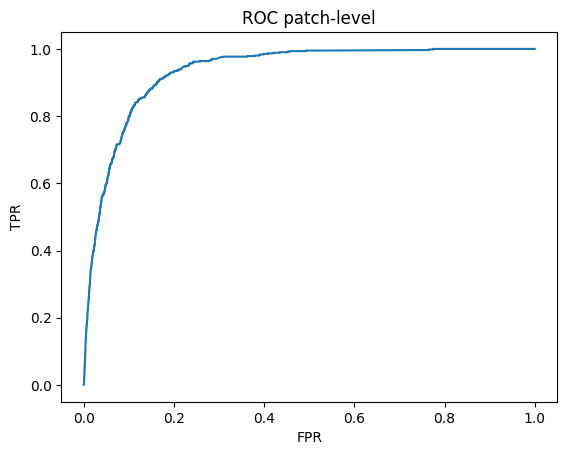

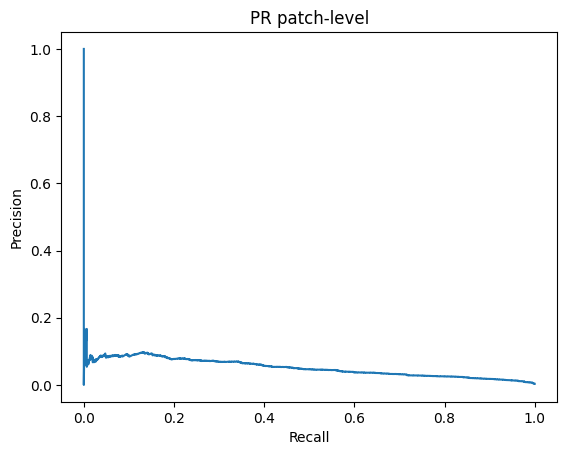

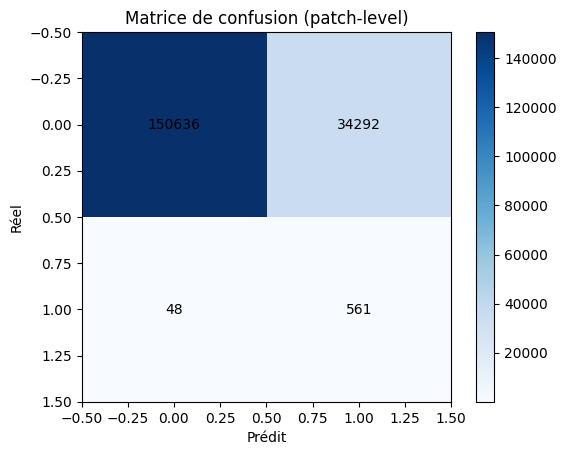

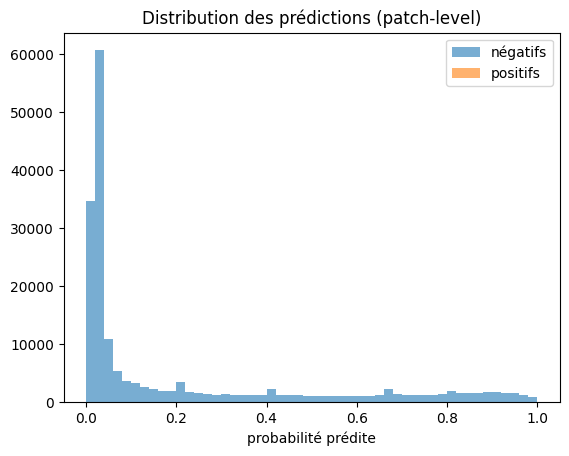


🧠 Agrégation patch → série...

=== Résultats série-level ===
AUC=0.532 | AP=0.401 | Acc=0.406 | Prec=0.401 | Rec=0.997
TP=345 FN=1 FP=516 TN=8


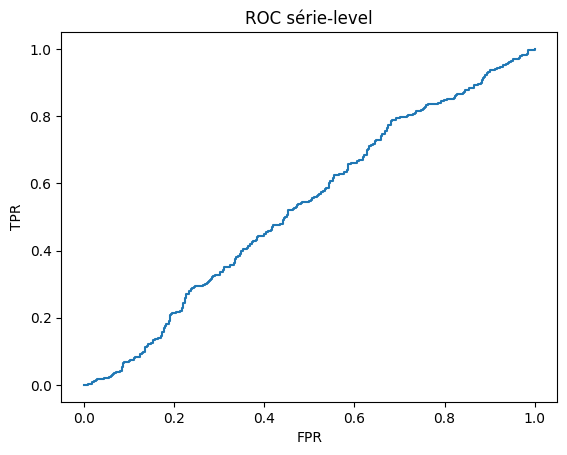

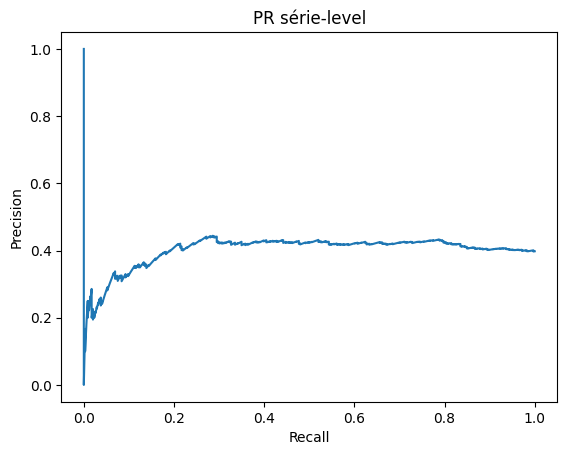

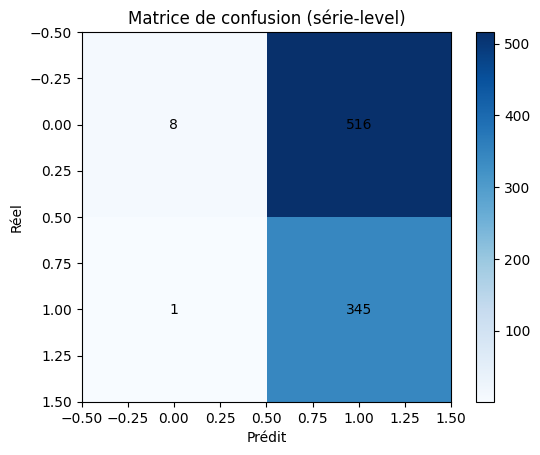

In [46]:
res = evaluate_series_ensemble(
    models=best_models,
    X_grp_patch=X_grp_patch,
    y_grp_patch=y_grp_patch,
    meta_grp_patch=meta_grp_patch,
    test_ids=splits["test"],
    batch_size=32,
    agg="max",
    threshold=0.5
)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, confusion_matrix

def evaluate_thresholds(y_true, y_pred_series, thresholds=None, plot=True):
    if thresholds is None:
        thresholds = np.logspace(-3, 0, 100)  # 0.001 → 1.0

    auc = roc_auc_score(y_true, y_pred_series)
    print(f"\nAUC global séries = {auc:.4f}")

    precisions, recalls, f1s, specs, bals = [], [], [], [], []

    for t in thresholds:
        y_pred_bin = (y_pred_series >= t).astype(int)
        TP = np.sum((y_true == 1) & (y_pred_bin == 1))
        FN = np.sum((y_true == 1) & (y_pred_bin == 0))
        FP = np.sum((y_true == 0) & (y_pred_bin == 1))
        TN = np.sum((y_true == 0) & (y_pred_bin == 0))

        prec = TP / (TP + FP + 1e-9)
        rec = TP / (TP + FN + 1e-9)
        spec = TN / (TN + FP + 1e-9)
        f1 = 2 * prec * rec / (prec + rec + 1e-9)
        bal = 0.5 * (rec + spec)

        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        specs.append(spec)
        bals.append(bal)

    # --- Trouve le meilleur seuil ---
    best_idx = np.argmax(f1s)
    best_t = thresholds[best_idx]
    print(f"\n>>> Seuil optimal ≈ {best_t:.4f}")
    print(f"F1={f1s[best_idx]:.3f} | Précision={precisions[best_idx]:.3f} | Rappel={recalls[best_idx]:.3f} | Spécificité={specs[best_idx]:.3f} | Balanced Acc={bals[best_idx]:.3f}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.semilogx(thresholds, precisions, label="Précision")
        plt.semilogx(thresholds, recalls, label="Rappel")
        plt.semilogx(thresholds, f1s, label="F1-score")
        plt.semilogx(thresholds, specs, label="Spécificité")
        plt.semilogx(thresholds, bals, label="Balanced Acc")
        plt.xlabel("Seuil (log)")
        plt.ylabel("Score")
        plt.title("Évolution des métriques selon le seuil (séries)")
        plt.legend()
        plt.grid(True, which="both")
        plt.show()

    return best_t, thresholds, f1s, precisions, recalls, specs, bals


In [ ]:
# y_true_series = vrais labels par série (0/1)
# y_pred_series = proba moyennes ou max par série (sortie modèle ou ensemble)

best_t, *_ = evaluate_thresholds(y_true_series, y_pred_series)